##### Copyright 2020 Google

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Optimization Analysis

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/experiments/qaoa/optimization_analysis"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/ReCirq/blob/master/docs/qaoa/optimization_analysis.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/ReCirq/blob/master/docs/qaoa/optimization_analysis.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/ReCirq/docs/qaoa/optimization_analysis.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

## Setup

Install the ReCirq package:

In [ ]:
try:
    import recirq
except ImportError:
    !pip install -q git+https://github.com/quantumlib/ReCirq sympy~=1.6

## Load Data
Go through each record, load in supporting objects, flatten everything into records, and put into a dataframe.

In [1]:
from datetime import datetime
import recirq
import cirq
import numpy as np
import pandas as pd
from recirq.qaoa.experiments.optimization_tasks import (
    DEFAULT_BASE_DIR,
    DEFAULT_PROBLEM_GENERATION_BASE_DIR)

records = []
for record in recirq.iterload_records(dataset_id="2020-03-tutorial", base_dir=DEFAULT_BASE_DIR):
    task = record['task']
    result = recirq.load(task, DEFAULT_BASE_DIR)
    pgen_task = task.generation_task
    problem = recirq.load(pgen_task, base_dir=DEFAULT_PROBLEM_GENERATION_BASE_DIR)['problem']
    record['problem'] = problem.graph
    record['problem_type'] = problem.__class__.__name__
    recirq.flatten_dataclass_into_record(record, 'task')
    records.append(record)
df = pd.DataFrame(records)    
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,timestamp,x,fun,nit,nfev,lowest_energy_found,best_bitstring_found,evaluated_points,bitstring_lists,energy_lists,...,optimal_angles_fun,problem,problem_type,dataset_id,generation_task,device_name,p,algorithm,x0,line_placement_strategy
0,2020-08-12 10:47:34.046188,"[0.3091960656314942, -0.31222192779577423]",-0.80848,10,71,-1.0,"[0, 1, 0]","[recirq.NumpyArray([0.3 0.2]), recirq.NumpyArr...",[recirq.BitArray([[0 1 0]\n [0 0 0]\n [1 1 1]\...,[recirq.NumpyArray([-1. 3. 3. ... 3. 3. 3...,...,-0.81088,"(0, 1, 2)",SKProblem,2020-03-tutorial,SKProblemGenerationTask(dataset_id='2020-03-tu...,Syc23-simulator,1,"OptimizationAlgorithm(method='MGD', n_shots=25...","[0.3, 0.2]",None
1,2020-08-12 10:46:52.953423,"[0.46700596149989154, -0.3960967452764799]",-1.38384,10,71,-3.0,"[1, 0, 1, 1]","[recirq.NumpyArray([0.3 0.2]), recirq.NumpyArr...",[recirq.BitArray([[0 0 0 1]\n [1 1 0 0]\n [1 1...,[recirq.NumpyArray([ 1. -1. 1. ... 3. 1. 1...,...,-1.39364,"(1, 2, 3, 0)",HardwareGridProblem,2020-03-tutorial,HardwareGridProblemGenerationTask(dataset_id='...,Syc23-simulator,1,"OptimizationAlgorithm(method='MGD', n_shots=25...","[0.3, 0.2]",None
2,2020-08-12 10:48:05.093354,"[0.2539034350243896, -0.2954098997546575]",-0.97392,10,71,-2.0,"[1, 0, 1, 0]","[recirq.NumpyArray([0.3 0.2]), recirq.NumpyArr...",[recirq.BitArray([[0 1 1 1]\n [1 0 1 0]\n [0 0...,[recirq.NumpyArray([ 0. -2. 0. ... -2. 0. 6...,...,-0.98040,"(0, 1, 3, 2)",ThreeRegularProblem,2020-03-tutorial,ThreeRegularProblemGenerationTask(dataset_id='...,Syc23-simulator,1,"OptimizationAlgorithm(method='MGD', n_shots=25...","[0.3, 0.2]",None


## Plot

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns
sns.set_style('ticks')

plt.rc('axes', labelsize=16, titlesize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14, title_fontsize=16)

In [3]:
# Load landscape data
from recirq.qaoa.experiments.p1_landscape_tasks import \
    DEFAULT_BASE_DIR, DEFAULT_PROBLEM_GENERATION_BASE_DIR, DEFAULT_PRECOMPUTATION_BASE_DIR, \
    ReadoutCalibrationTask

records = []
ro_records = []
for record in recirq.iterload_records(dataset_id="2020-03-tutorial", base_dir=DEFAULT_BASE_DIR):
    record['timestamp'] = datetime.fromisoformat(record['timestamp'])
    dc_task = record['task']
    
    if isinstance(dc_task, ReadoutCalibrationTask):
        ro_records.append(record)
        continue
    
    pgen_task = dc_task.generation_task    
    problem = recirq.load(pgen_task, base_dir=DEFAULT_PROBLEM_GENERATION_BASE_DIR)['problem']
    record['problem'] = problem.graph
    record['problem_type'] = problem.__class__.__name__
    record['bitstrings'] = record['bitstrings'].bits
    recirq.flatten_dataclass_into_record(record, 'task')
    recirq.flatten_dataclass_into_record(record, 'generation_task')    
    records.append(record)
    
# Associate each data collection task with its nearest readout calibration
for record in sorted(records, key=lambda x: x['timestamp']):
    record['ro'] = min(ro_records, key=lambda x: abs((x['timestamp']-record['timestamp']).total_seconds()))
    
df_raw = pd.DataFrame(records)    
df_raw.head()

from recirq.qaoa.simulation import hamiltonian_objectives

def compute_energies(row):
    permutation = []
    qubit_map = {}
    final_qubit_index = {q: i for i, q in enumerate(row['final_qubits'])}
    for i, q in enumerate(row['qubits']):
        fi = final_qubit_index[q]
        permutation.append(fi)
        qubit_map[i] = q
        
    return hamiltonian_objectives(row['bitstrings'], 
                                  row['problem'], 
                                  permutation,
                                  row['ro']['calibration'],
                                  qubit_map)

# Start cleaning up the raw data
landscape_df = df_raw.copy()
landscape_df = landscape_df.drop(['line_placement_strategy', 
              'generation_task.dataset_id', 
              'generation_task.device_name'], axis=1)

# Compute energies
landscape_df['energies'] = landscape_df.apply(compute_energies, axis=1)
landscape_df = landscape_df.drop(['bitstrings', 'problem', 'ro', 'qubits', 'final_qubits'], axis=1)
landscape_df['energy'] = landscape_df.apply(lambda row: np.mean(row['energies']), axis=1)

# We won't do anything with raw energies right now
landscape_df = landscape_df.drop('energies', axis=1)

# Do timing somewhere else
landscape_df = landscape_df.drop([col for col in landscape_df.columns if col.endswith('_time')], axis=1)

In [4]:
import scipy.interpolate
from recirq.qaoa.simulation import lowest_and_highest_energy

def get_problem_graph(problem_type,
                    n=None,
                    instance_i=0):
    if n is None:
        if problem_type == 'HardwareGridProblem':
            n = 4
        elif problem_type == 'SKProblem':
            n = 3
        elif problem_type == 'ThreeRegularProblem':
            n = 4
        else:
            raise ValueError(repr(problem_type))
    
    r = df_raw[
        (df_raw['problem_type']==problem_type)&
        (df_raw['n_qubits']==n)&
        (df_raw['instance_i']==instance_i)
    ]['problem']
    return r.iloc[0]

def plot_optimization_path_in_landscape(problem_type, res=200, method='nearest', cmap='PuOr'):
    optimization_data = df[df['problem_type'] == problem_type]
    landscape_data = landscape_df[landscape_df['problem_type'] == problem_type]
    xx, yy = np.meshgrid(np.linspace(0, np.pi/2, res), np.linspace(-np.pi/4, np.pi/4, res))
    x_iters = optimization_data['x_iters'].values[0]
    
    min_c, max_c = lowest_and_highest_energy(get_problem_graph(problem_type))
    zz = scipy.interpolate.griddata(
        points=landscape_data[['gamma', 'beta']].values,
        values=landscape_data['energy'].values / min_c,
        xi=(xx, yy),
        method=method,
    )

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    norm = plt.Normalize(max_c/min_c, min_c/min_c)
    cmap = 'RdBu'
    extent=(0, 4, -2, 2)
    
    g = ax.imshow(zz, extent=extent, origin='lower', cmap=cmap, norm=norm, interpolation='none')
    xs, ys = zip(*x_iters)
    xs = np.array(xs) / (np.pi / 8)
    ys = np.array(ys) / (np.pi / 8)
    ax.plot(xs, ys, 'r-')
    ax.plot(xs[0], ys[0], 'rs')### Hardware Grid
    ax.plot(xs[1:-1], ys[1:-1], 'r.')
    ax.plot(xs[-1], ys[-1], 'ro')
    x, y = optimization_data['optimal_angles'].values[0]
    x /= (np.pi / 8)
    y /= (np.pi / 8)
    ax.plot(x, y, 'r*')
    
    ax.set_xlabel(r'$\gamma\ /\ (\pi/8)$')
    ax.set_ylabel(r'$\beta\ /\ (\pi/8)$')
    ax.set_title('Optimization path in landscape')

    fig.colorbar(g, ax=ax, shrink=0.8)
    
def plot_function_values(problem_type):
    data = df[df['problem_type'] == problem_type]
    function_values = data['func_vals'].values[0]
    min_c, _ = lowest_and_highest_energy(get_problem_graph(problem_type))
    function_values = np.array(function_values) / min_c
    x = range(len(function_values))
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    ax.plot(x, function_values, 'o--')
    ax.set_xlabel('Optimization iteration')
    ax.set_ylabel(r'$E / E_{min}$')
    ax.set_title('Optimization function values')

### Hardware Grid

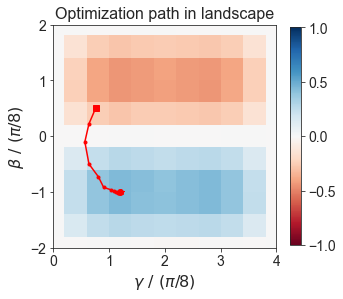

In [5]:
plot_optimization_path_in_landscape('HardwareGridProblem')

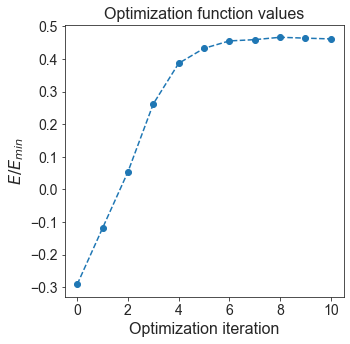

In [6]:
plot_function_values('HardwareGridProblem')

### SK Model

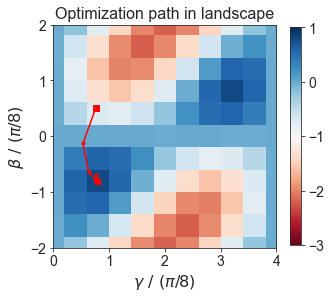

In [7]:
plot_optimization_path_in_landscape('SKProblem')

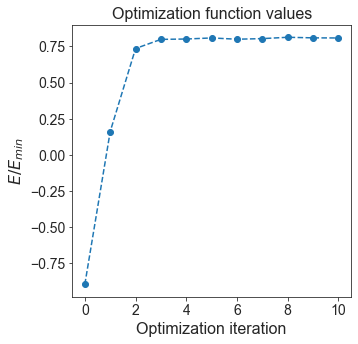

In [8]:
plot_function_values('SKProblem')

### 3 Regular MaxCut

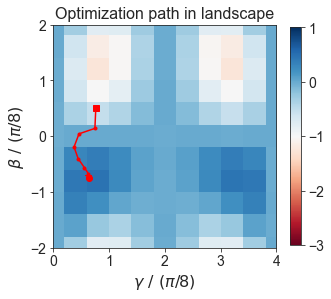

In [9]:
plot_optimization_path_in_landscape('ThreeRegularProblem')

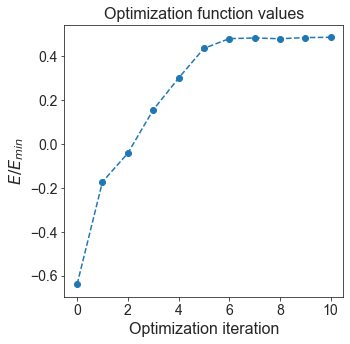

In [10]:
plot_function_values('ThreeRegularProblem')